# FastQC report inspection

This document provides intruction on how to inspect some FastQC reports systematically. This step generates a series of plots for quality control purpose.

## Quantification of Per Tile Quality plots reported by FastQC 

### Step 1: Obtain statistics generated by FastQC 

### Step 2: Quantify the Per Tile Quality plots

FastQC reports a plot for Per Tile Quality, which can be interpreted as: "The plot shows the deviation from the average quality for each tile. The colours are on a cold to hot scale, with cold colours being positions where the quality was at or above the average for that base in the run, and hotter colours indicate that a tile had worse qualities than other tiles for that base. In the example below you can see that certain tiles show consistently poor quality. A good plot should be blue all over." (https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/12%20Per%20Tile%20Sequence%20Quality.html) <br>
Based on this idea, we would like to quatify the amount of "red" tiles and "blue" tiles so we can compare this aspect across all samples. 

In [1]:
library("ggplot2")
library("tidyr")
suppressPackageStartupMessages(library("dplyr"))

In [2]:
files <- list.files("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/", pattern = "per_tile_qual.txt", recursive = TRUE)
length(files)

[1] 1104

In [3]:
metadata <- read.table("/nfs/turbo/umms-scjp-pank/4_integration/data/202503_freeze/20250314_meta_runs.txt", header = T)

In [4]:
df <- data.frame(files = unlist(lapply(strsplit(files, '_fastqc/', fixed = TRUE), '[', 1)),
                 n_tiles = NA, n_bases = NA, meanScores = NA)
df$samples <- unlist(lapply(strsplit(df$files, '_', fixed = TRUE), '[', 1))
df <- inner_join(df, distinct(metadata[, c("srr", "source")]), by = c("samples" = "srr"))
head(df)

,files,n_tiles,n_bases,meanScores,samples,source
,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<chr>
1,HPAP-019_10xscRNA_71783.L001.R1_fastq-data,NA,NA,NA,HPAP-019,HPAP
2,HPAP-019_10xscRNA_71783.L001.R2_fastq-data,NA,NA,NA,HPAP-019,HPAP
3,HPAP-019_10xscRNA_71783.L004.R1_fastq-data,NA,NA,NA,HPAP-019,HPAP
4,HPAP-019_10xscRNA_71783.L004.R2_fastq-data,NA,NA,NA,HPAP-019,HPAP
5,HPAP-019_10xscRNA_71783.L006.R1_fastq-data,NA,NA,NA,HPAP-019,HPAP
6,HPAP-019_10xscRNA_71783.L006.R2_fastq-data,NA,NA,NA,HPAP-019,HPAP


In [5]:
fastqc <- read.table("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/perTile-status-check.txt", sep=' ', header=F, fill = T, as.is=T, check.names=F)
colnames(fastqc) <- c("files", "Per Tile Sequence Quality")
fastqc$samples <- unlist(lapply(strsplit(fastqc$files, '_fastqc', fixed = TRUE), '[', 1))
fastqc <- fastqc[, c("samples", "Per Tile Sequence Quality")]
head(fastqc)
dim(fastqc)

,samples,Per Tile Sequence Quality
,<chr>,<chr>
1,HPAP-019_10xscRNA_71783.L001.R1_fastq-data,pass
2,HPAP-019_10xscRNA_71783.L001.R2_fastq-data,warn
3,HPAP-019_10xscRNA_71783.L004.R1_fastq-data,pass
4,HPAP-019_10xscRNA_71783.L004.R2_fastq-data,warn
5,HPAP-019_10xscRNA_71783.L006.R1_fastq-data,fail
6,HPAP-019_10xscRNA_71783.L006.R2_fastq-data,fail


[1] 1104    2

At this stage, we can observe that some sequencing files do not have Per Tile Quality reports. This could be because these files do not have enough flow cell information to generate this plot. We print these file names here for manual inspection, but remove from the current object for the next step.

In [6]:
fastqc[fastqc$`Per Tile Sequence Quality` == "",]

,samples,Per Tile Sequence Quality
,<chr>,<chr>
479,HPAP-108_FGC2390_109360_S20_L002_R1_001,
480,HPAP-108_FGC2390_109360_S20_L002_R2_001,
609,SRR12831415_1,
610,SRR12831415_2,
611,SRR12831416_1,
612,SRR12831416_2,
613,SRR12831417_1,
614,SRR12831417_2,
615,SRR12831418_1,


In [7]:
fastqc <- fastqc[fastqc$`Per Tile Sequence Quality` != "",]
dim(fastqc)

[1] 1092    2

In [8]:
df <- inner_join(df, fastqc, by = c("files" = "samples"))
head(df)

,files,n_tiles,n_bases,meanScores,samples,source,Per Tile Sequence Quality
,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>
1,HPAP-019_10xscRNA_71783.L001.R1_fastq-data,NA,NA,NA,HPAP-019,HPAP,pass
2,HPAP-019_10xscRNA_71783.L001.R2_fastq-data,NA,NA,NA,HPAP-019,HPAP,warn
3,HPAP-019_10xscRNA_71783.L004.R1_fastq-data,NA,NA,NA,HPAP-019,HPAP,pass
4,HPAP-019_10xscRNA_71783.L004.R2_fastq-data,NA,NA,NA,HPAP-019,HPAP,warn
5,HPAP-019_10xscRNA_71783.L006.R1_fastq-data,NA,NA,NA,HPAP-019,HPAP,fail
6,HPAP-019_10xscRNA_71783.L006.R2_fastq-data,NA,NA,NA,HPAP-019,HPAP,fail


From here, we need to employ FastQC source code that encodes the color scales of plots. This source code can be found here: https://github.com/s-andrews/FastQC/blob/master/uk/ac/babraham/FastQC/Utilities/HotColdColourGradient.java As we want to quantify the the amount of "red" tiles and "blue" tiles, it is important to note that according to this code, depending on the actual value of each tile, one tile may have some red values. However, if the tile is high quality (quality was at or above the average), the red values will be lower than blue. <br>
The following chunk of code is the translation of Java code to R:

In [9]:
### adapt from FastQC source code 
RGB <- function(r, g, b) {
  list(r = r, g = g, b = b)
}

makeColors = function() {
    colors <- vector("list", 100)
      
    # Define min and max based on provided Java logic
    min <- 0 - sqrt(50)
    max <- sqrt(99 - 50)
      
    for (c in 1:100) {
        actualC <- c - 51
        if (actualC < 0) actualC <- -actualC
        corrected <- sqrt(actualC)
        if (c < 51 && corrected > 0) corrected <- -corrected
        rgb <- getRGB(corrected, min, max)
        colors[[c]] <- rgb
    }
      
    return(colors)
}

getColor = function(value, min, max) {
      percentage <- (100 * (value - min)) / (max - min)
      percentage <- max(1, min(100, round(percentage)))

      return(colors[[percentage]])
}

getRGB = function(value, min, max) {
    # Red
    # Red is 0 for the first 50%, scales from 0-200 over 50-75%
    # and stays at 200 from 75-100%

    # Green
    # Green scales from 0-200 over the first 25%, stays at
    # 200 from 25-75% and then scales from 200-0 from 75-100%

    # Blue
    # Blue starts at 200 until 25%, then scales from 200-0
    # from 25-50%, then stays at 0 until 100%

    # Since all transitions happen in quarters of the spectrum
    # range it's easiest to deal with colour values in those
    # ranges

    red <- 0
    green <- 0
    blue <- 0
      
    diff <- max - min
      
    if (value < (min + (diff * 0.25))) {
        red <- 0
        blue <- 200
        green <- round(200 * ((value - min) / (diff * 0.25)))
    } else if (value < (min + (diff * 0.5))) {
        red <- 0
        green <- 200
        blue <- round(200 - (200 * ((value - (min + (diff * 0.25))) / (diff * 0.25))))
    } else if (value < (min + (diff * 0.75))) {
        green <- 200
        blue <- 0
        red <- round(200 * ((value - (min + (diff * 0.5))) / (diff * 0.25)))
    } else {
        red <- 200
        blue <- 0
        green <- round(200 - (200 * ((value - (min + (diff * 0.75))) / (diff * 0.25))))
    }
      
    return(RGB(red, green, blue))
}

In [10]:
colors <- makeColors()
colors[1]

[[1]]
[[1]]$r
[1] 0

[[1]]$g
[1] 0

[[1]]$b
[1] 200

We focus on quatifying the "red" values:

In [11]:
for (s in df$files) {
    f <- read.table(paste0("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/", s, "_fastqc/per_tile_qual.txt"), comment.char = "", sep='\t', header=T, as.is=T, check.names=F)
    colnames(f)[1] <- "Tile"
    f$Mean <- -f$Mean #https://github.com/s-andrews/FastQC/blob/master/uk/ac/babraham/FastQC/Graphs/TileGraph.java#L146 0-tileBaseMeans[tile][base]
    
    if (df[df$files == s, "Per Tile Sequence Quality"] != "pass") {
        f$red <- sapply(f$Mean, function(mean_value) {
          cols <- getColor(mean_value, 0, max(f$Mean)) #https://github.com/s-andrews/FastQC/blob/master/uk/ac/babraham/FastQC/Graphs/TileGraph.java#L146 gradient.getColor(0-tileBaseMeans[tile][base], 0, ...)
          ifelse(cols$b == 0, 1, 0) # if a tile blue color is 0, it means the tile must have some red. `1` here means having red or not
        })
    } else {
        f$red <- sapply(f$Mean, function(mean_value) {
          cols <- getColor(mean_value, 0, sqrt(99 - 50)) #https://github.com/s-andrews/FastQC/blob/master/uk/ac/babraham/FastQC/Graphs/TileGraph.java#L146 gradient.getColor(0-tileBaseMeans[tile][base], 0, ...)
          ifelse(cols$b == 0, 1, 0)
        })
    }

    nbases <- length(unique(f$Base))
    nTiles <- f %>% group_by(Tile) %>% 
                    summarise(below = sum(red == 1)) %>% 
                    filter(below > 0) %>% summarise(n = sum(below > 0))
    df[df$files == s, "n_tiles"] <- nTiles$n/length(unique(f[, "Tile"]))
    # n_tiles is the fraction of tiles that have red color (i.e., may have worse qualities than other tiles)
    
    ntiles <- length(unique(f$Tile))
    nBases <- f %>% group_by(Base) %>% 
                    summarise(below = sum(red == 1)) %>% 
                    filter(below > 0) %>% summarise(n = sum(below > 0))
    df[df$files == s, "n_bases"] <- nBases$n/length(unique(f$Base))
    # n_bases is the fraction of bases that have red color (i.e., may have worse qualities than other bases)
    
    df[df$files == s, "meanScores"] <- ifelse(is.na(sum(f[f$red > 0, "Mean"])), 0, sum(f[f$red > 0, "Mean"]))
}

In [12]:
df$labels <- ifelse(df$n_bases > 0.5 & df$n_tiles > 0.4, df$files, '')
df$labels <- gsub("_fastq-data", "", gsub("_10xscRNA", "", df$labels))

In [13]:
head(df, 3)

,files,n_tiles,n_bases,meanScores,samples,source,Per Tile Sequence Quality,labels
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,HPAP-019_10xscRNA_71783.L001.R1_fastq-data,0.00000000,0.0000000,0.00000,HPAP-019,HPAP,pass,
2,HPAP-019_10xscRNA_71783.L001.R2_fastq-data,0.05357143,0.2037037,60.67555,HPAP-019,HPAP,warn,
3,HPAP-019_10xscRNA_71783.L004.R1_fastq-data,0.00000000,0.0000000,0.00000,HPAP-019,HPAP,pass,


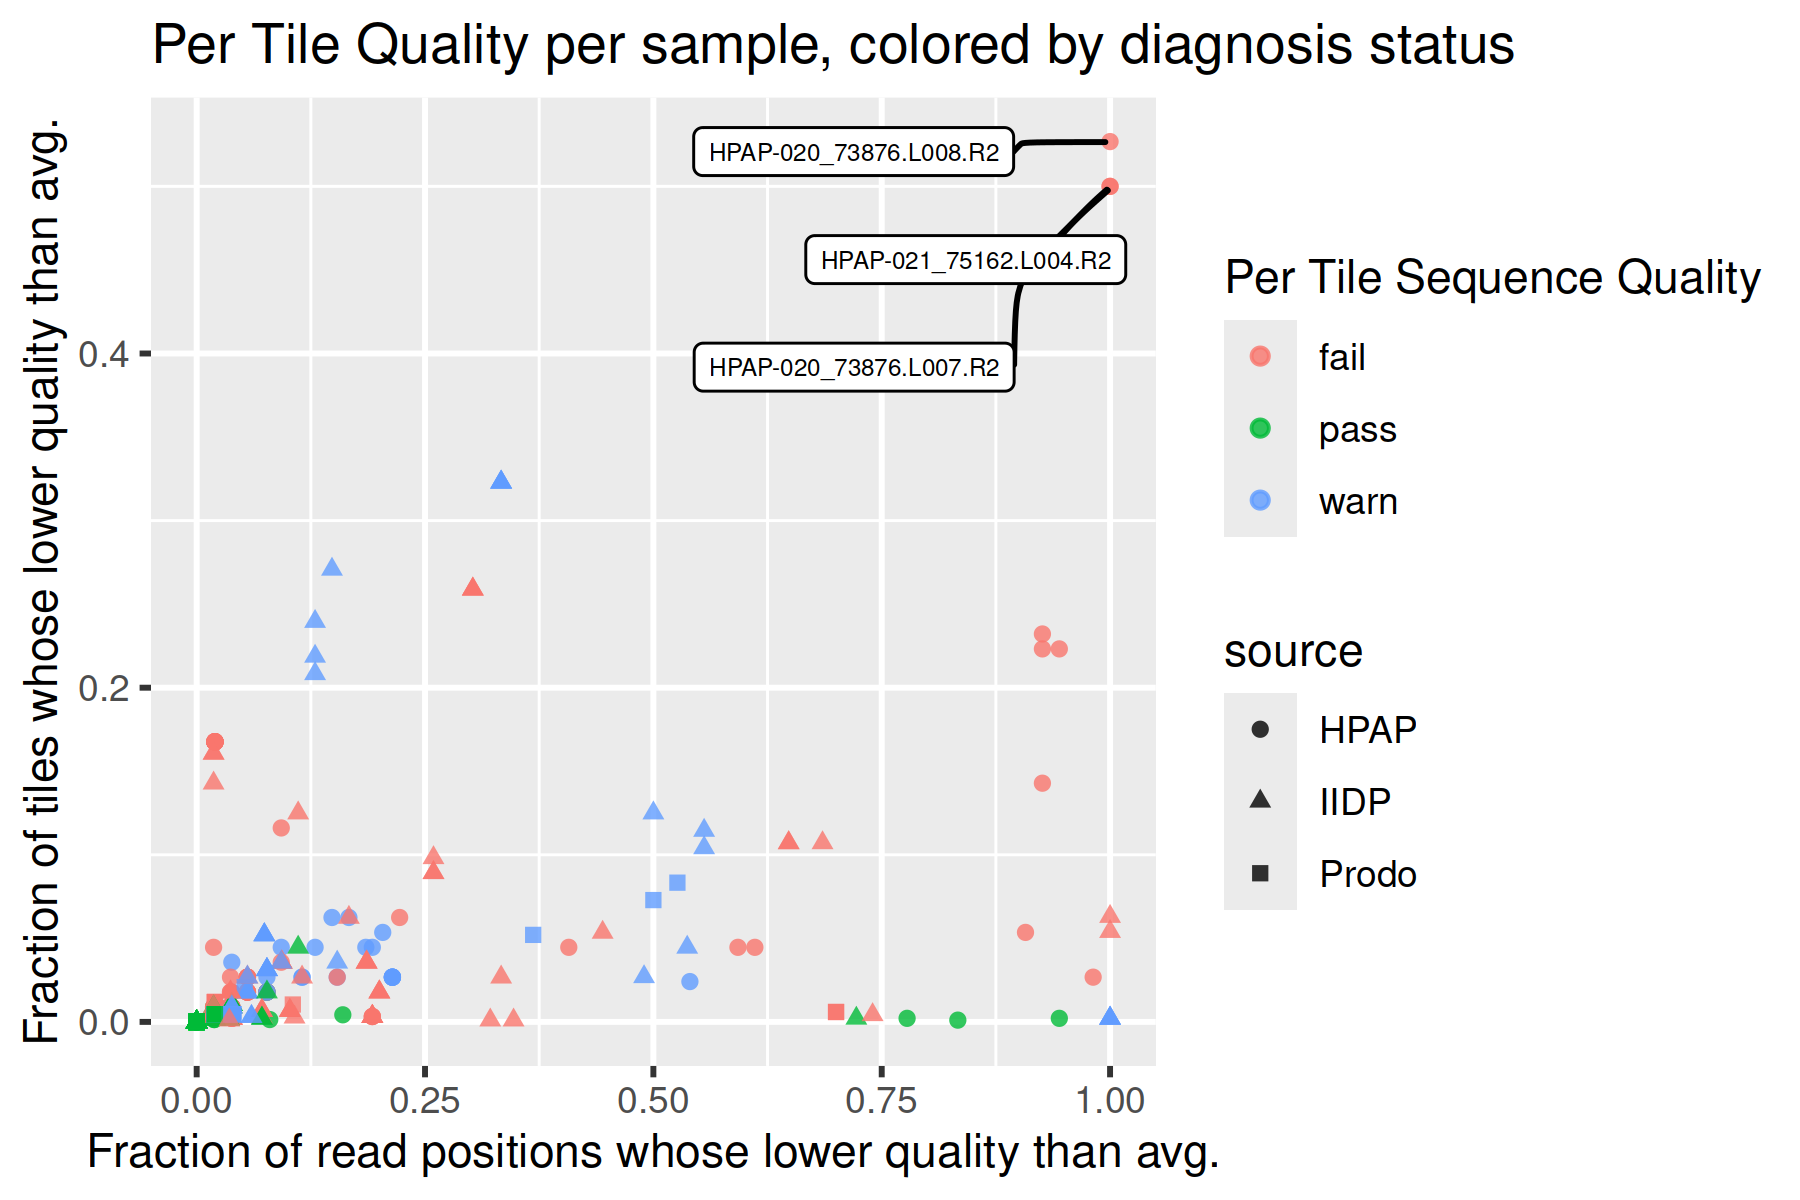

In [14]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)

ggplot(df, aes(x=n_bases, y=n_tiles, group = source)) +
    geom_point(aes(shape = source, color = `Per Tile Sequence Quality`), alpha = 0.8) + 
    xlab("Fraction of read positions whose lower quality than avg.") +
    ylab("Fraction of tiles whose lower quality than avg.") +
    ggtitle("Per Tile Quality per sample, colored by diagnosis status") +
    ggrepel::geom_label_repel(aes(label = labels), max.overlaps = Inf, box.padding = 0.5, size = 2,
                                  segment.curvature = -0.1, segment.ncp = 3, segment.angle = 20)

Based on this scatter plot, it is clear there are three sequencing files that may have lower quality and should be excluded. The following plots correspond to these sequencing files.

HPAP-020_10xscRNA_73876.L008.R2_fastq-data:

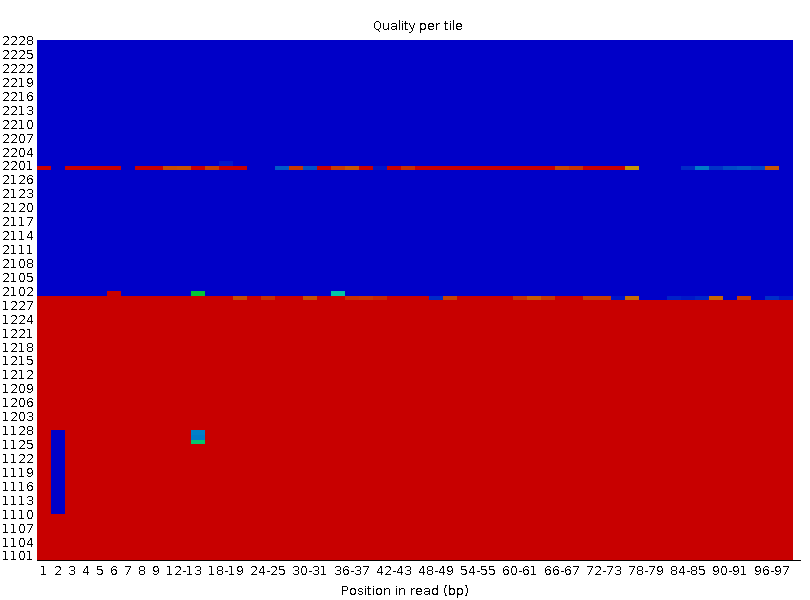

In [15]:
library(IRdisplay)

img_raw <- readBin("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-020_10xscRNA_73876.L008.R2_fastq-data_fastqc/Images/per_tile_quality.png", what = "raw", 
                   n = file.info("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-020_10xscRNA_73876.L008.R2_fastq-data_fastqc/Images/per_tile_quality.png")$size)
display_png(img_raw)

HPAP-020_10xscRNA_73876.L007:

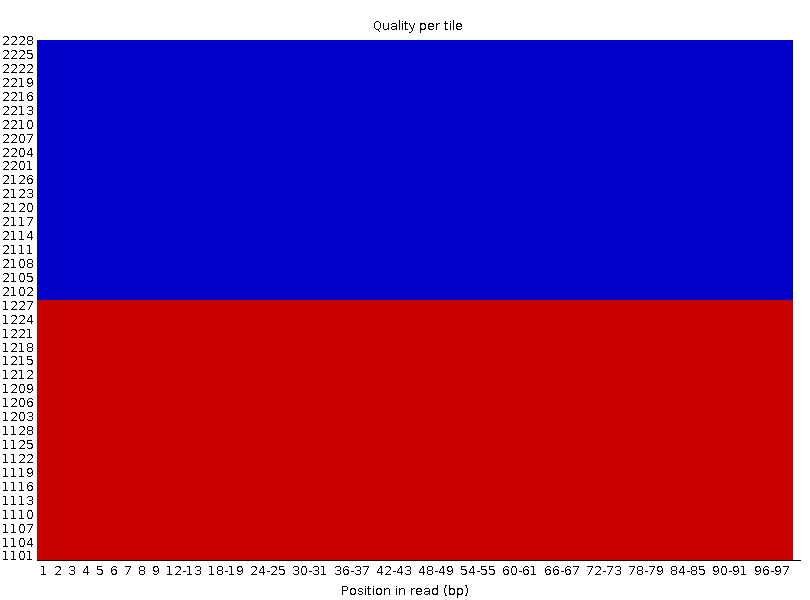

In [16]:
library(IRdisplay)
img_raw <- readBin("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-020_10xscRNA_73876.L007.R2_fastq-data_fastqc/Images/per_tile_quality.png", what = "raw", 
                   n = file.info("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-020_10xscRNA_73876.L007.R2_fastq-data_fastqc/Images/per_tile_quality.png")$size)
display_png(img_raw)

HPAP-021_10xscRNA_75162.L004:

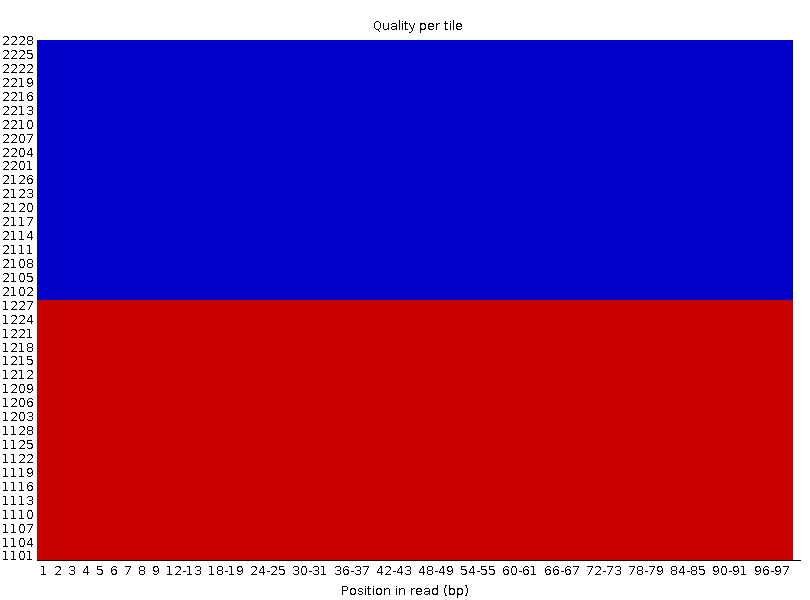

In [17]:
library(IRdisplay)
img_raw <- readBin("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-021_10xscRNA_75162.L004.R2_fastq-data_fastqc/Images/per_tile_quality.png", what = "raw",
                   n = file.info("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-021_10xscRNA_75162.L004.R2_fastq-data_fastqc/Images/per_tile_quality.png")$size)
display_png(img_raw)

### Step 3: Manually inspect sequencing files that do not have Per Tile Quality plots

Quality of most files are good; however, the Per Base Quality plot of HPAP-108_FGC2390_109360_S20_L002 seems to need attention. Upon inspecting further, it turns out that this file contains only one read. Therefore, we removed data from this file from downstream analysis.

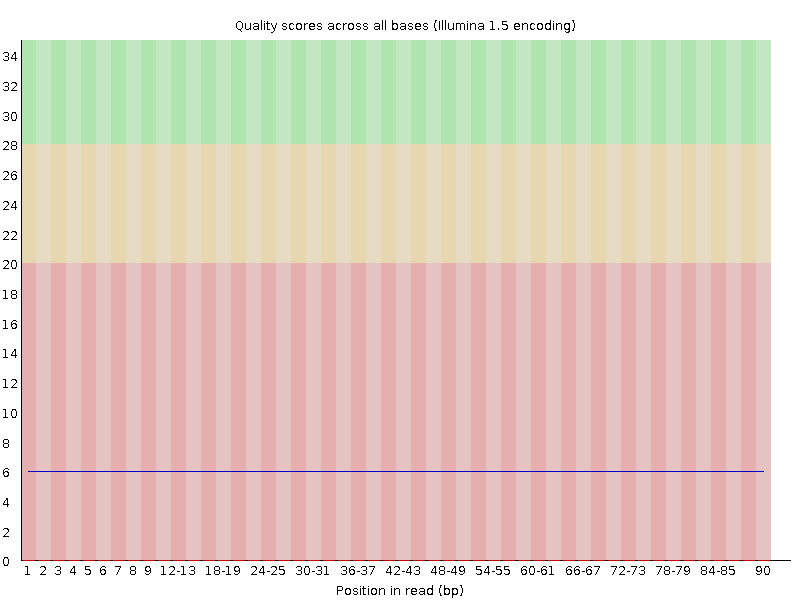

In [18]:
library(IRdisplay)
img_raw <- readBin("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-108_FGC2390_109360_S20_L002_R2_001_fastqc/Images/per_base_quality.png", what = "raw",
                   n = file.info("/nfs/turbo/umms-scjp-pank/4_integration/data/202412_freeze/fastqc/fastqc/HPAP-108_FGC2390_109360_S20_L002_R2_001_fastqc/Images/per_base_quality.png")$size)
display_png(img_raw)